In [1]:
from astropy.table import Table
import astropy.cosmology as apc
import numpy as np
import matplotlib.pyplot as plt
import h5py

%matplotlib inline

In [2]:
data = Table.read("../sdss_dr15/skyserver_results.fits")
print('number of QSO', len(data[data['class']=='QSO']))
print('number of GALAXY', len(data[data['class']=='GALAXY']))
ii_gal = data['class']=='GALAXY'
gal_data = data[ii_gal]

number of QSO 30387
number of GALAXY 191681


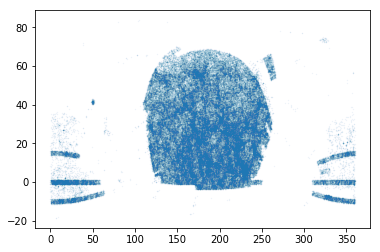

In [3]:
plt.scatter(gal_data['ra'], gal_data['dec'], alpha=0.1, s=0.1)

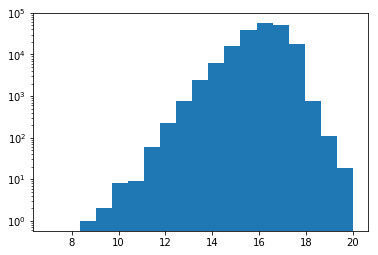

In [4]:
_ = plt.hist(gal_data['r'], bins=np.linspace(7,20,20), log=True)

111


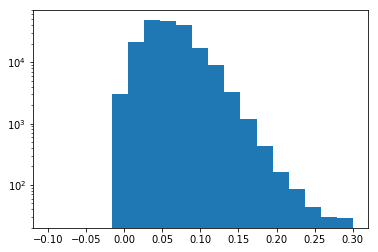

In [5]:
_ = plt.hist(gal_data['redshift'], bins=np.linspace(-0.1,0.3,20), log=True)
print(np.count_nonzero(gal_data['redshift']<0.0))

In [6]:
def write_data_set(gal_data, cosmology, cosmology_name='Planck15'):
    gal_data['theta'] = np.deg2rad(90-gal_data['dec'])
    gal_data['phi'] = np.deg2rad((gal_data['ra'] - (90+45))%360.0)
    gal_data['r_comoving'] = cosmology.comoving_distance(gal_data['redshift'])
    gal_data['z_coord'] = gal_data['r_comoving'] * np.cos(gal_data['theta'])
    gal_data['y_coord'] = gal_data['r_comoving'] * np.sin(gal_data['theta']) * np.sin(gal_data['phi'])
    gal_data['x_coord'] = gal_data['r_comoving'] * np.sin(gal_data['theta']) * np.cos(gal_data['phi'])
    ii_mask = (gal_data['theta'] < np.pi/2)  
    ii_mask &= (gal_data['theta']>np.pi/4) 
    ii_mask &= (gal_data['phi']>0.0) 
    ii_mask &= (gal_data['phi']<np.pi/2.0) 
    ii_mask &= (gal_data['r_comoving']>0.0)
    ii_mask &= (gal_data['r_comoving']<200.0)
    gal_data_mask = gal_data[ii_mask]

    print(len(gal_data_mask))
    output_filename = '../sdss_dr15/{}_SDSS_corner_cartesian.hdf5'.format(cosmology_name)
    h5f = h5py.File(output_filename, 'w')
    h5f.create_dataset('u', data=gal_data_mask['u'])
    h5f.create_dataset('g', data=gal_data_mask['g'])
    h5f.create_dataset('r', data=gal_data_mask['r'])
    h5f.create_dataset('z_coord', data=gal_data_mask['z_coord'])
    h5f.create_dataset('y_coord', data=gal_data_mask['y_coord'])
    h5f.create_dataset('x_coord', data=gal_data_mask['x_coord'])
    h5f.close()
    
    f = h5py.File(output_filename, 'r')
    x = f['x_coord'][:]
    y = f['y_coord'][:]
    z = f['z_coord'][:]
    f.close()
    pos = np.array([x,y,z])
    out_ascii_filename = '../sdss_dr15/{}_SDSS_corner_cartesian_pos.txt'.format(cosmology_name)
    np.savetxt(out_ascii_filename, pos.T)
    return gal_data_mask

In [7]:
# redefining coordinates
planck15 = apc.Planck15
planck15.H0
print(planck15.name, planck15.H0, planck15.Tcmb0)
gal_data_mask = write_data_set(gal_data, planck15, cosmology_name=planck15.name)
for omega_dm in np.linspace(0.1,1.0,10):
    for omega_de in np.linspace(0.1, 1.0, 10):
        name='omega_dm_{:.1f}_omega_de_{:.1f}'.format(omega_dm, omega_de)
        print(name)
        cosmo = apc.LambdaCDM(H0=planck15.H0, Om0=omega_dm, Ode0=omega_de, Tcmb0=planck15.Tcmb0, name=name)
        gal_data_mask = write_data_set(gal_data, cosmo, cosmology_name=cosmo.name)

Planck15 67.74 km / (Mpc s) 2.7255 K
32277
omega_dm_0.1_omega_de_0.1
32808
omega_dm_0.1_omega_de_0.2
32705
omega_dm_0.1_omega_de_0.3
32595
omega_dm_0.1_omega_de_0.4
32486
omega_dm_0.1_omega_de_0.5
32381
omega_dm_0.1_omega_de_0.6
32255
omega_dm_0.1_omega_de_0.7
32162
omega_dm_0.1_omega_de_0.8
32053
omega_dm_0.1_omega_de_0.9
31915
omega_dm_0.1_omega_de_1.0
31808
omega_dm_0.2_omega_de_0.1
32882
omega_dm_0.2_omega_de_0.2
32760
omega_dm_0.2_omega_de_0.3
32652
omega_dm_0.2_omega_de_0.4
32551
omega_dm_0.2_omega_de_0.5
32441
omega_dm_0.2_omega_de_0.6
32325
omega_dm_0.2_omega_de_0.7
32209
omega_dm_0.2_omega_de_0.8
32109
omega_dm_0.2_omega_de_0.9
31978
omega_dm_0.2_omega_de_1.0
31862
omega_dm_0.3_omega_de_0.1
32948
omega_dm_0.3_omega_de_0.2
32813
omega_dm_0.3_omega_de_0.3
32712
omega_dm_0.3_omega_de_0.4
32597
omega_dm_0.3_omega_de_0.5
32493
omega_dm_0.3_omega_de_0.6
32388
omega_dm_0.3_omega_de_0.7
32263
omega_dm_0.3_omega_de_0.8
32163
omega_dm_0.3_omega_de_0.9
32061
omega_dm_0.3_omega_de_1.0
319

Text(0,0.5,'z')

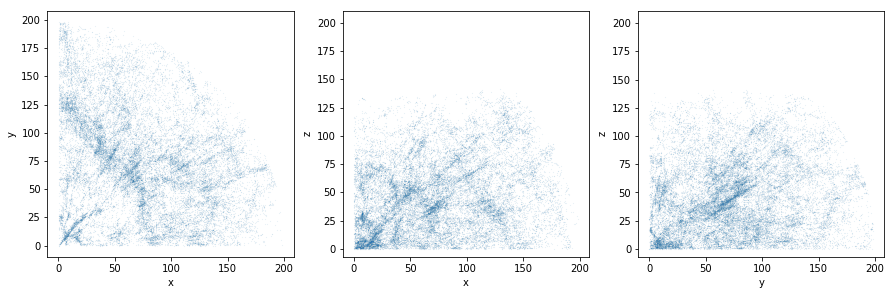

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
_ = plt.scatter(gal_data_mask['x_coord'], gal_data_mask['y_coord'], s=0.001)
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1,3,2)
_ = plt.scatter(gal_data_mask['x_coord'], gal_data_mask['z_coord'], s=0.001)
plt.axis('square')
plt.xlabel('x')
plt.ylabel('z')

plt.subplot(1,3,3)
_ = plt.scatter(gal_data_mask['y_coord'], gal_data_mask['z_coord'], s=0.001)
plt.axis('square')
plt.xlabel('y')
plt.ylabel('z')

Text(0,0.5,'y')

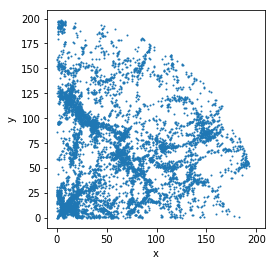

In [9]:
ii=gal_data_mask['z_coord']<20.0
plt.scatter(gal_data_mask['x_coord'][ii], gal_data_mask['y_coord'][ii], s=1.0)
plt.axis('square')
plt.xlabel('x')
plt.ylabel('y')